In [1]:
from notebook.services.config import ConfigManager
cm = ConfigManager()
cm.update('livereveal', {
        'width': 1024,
        'height': 768,
        'scroll': True,
})
%config InlineBackend.figure_format = 'retina'
from IPython.lib.display import YouTubeVideo

# Week 08, ASTR 596: Fundamentals of Data Science


## Time-series Analysis

### Gautham Narayan 
##### <gsn@illinois.edu>

# <center> How was Spring Break? </center>

### Back in week 1, I claimed that we only ever measured three things in astrophysics
1. Angular separations 
2. Energy differences
3. Time differences

### The first two feature explictly on your midterm (read the Riess and Humphreys et al. papers), but the third is implict. 

### We have periods for cepheids, but where did they come from?

## What is a time-series?

We observe a source not just once, but often have several repeated observations

# $$ (t_1, m_1), (t_2, m_2), ... , (t_N, m_n) $$

A **time-series** is any sequene of observation such that the distribution of $m_k$ depends on $m_{k-1}, m_{k-2}...$.
Time is an **exogeneous** (outside the model) variable that is **directional** - measuremets only depend on the past.
This is a statement of **causality**. 

Applies to astronomical measurements, your brain's electrical activity, the stock market, number of infected people...

These observations are typically not uniformly sampled - nor can they be from Earth even in principle (rotation, revolution). 

Virtually all statistical methods assume uniform sampling.  



## Why should you care?

Everything changes.

<table>
    <tr>
        <td><img src="transient_sky.jpg" width=100%></td>
    </tr>
</table>

credit: Francisco Forster (ALeRCE broker team)

# In-class Exercise: What statistical questions can you ask of a time-series

### [Our World in Data COVID Portal](https://ourworldindata.org/covid-cases)

## Discussion - Each year has seen a spike in COVID deaths in Winter-> Spring. Do you predict one for 2023?

What you are doing is a combination of **trend detection** and **forecasting**

# In-class Exercise: What statistical questions can you ask of a time-series


<table>
    <tr>
        <td><img src="cow.png" width=100%></td>
    </tr>
</table>

## What jumps out at you? Speculate as to why. How might you model this?

What you are doing is a combination of **trend detection**, **forecasting**, and **period finding** 

# In-class Exercise: What statistical questions can you ask of a time-series


<table>
    <tr>
        <td><img src="tsunami.jpg" width=100%></td>
    </tr>
</table>

## When did the earthquake begin and end? When did the main shocks of the Boxing Day Tsunami happen? How far apart are they?

What you are doing is a combination of **event finding** and **change point detection**. 

## What statistical questions can you ask of a time-series

1. Trend detection
2. Periodicity detection
3. Event detection
4. Point of change detection
5. Forecasting

All of which are linked to each other. Note that none of these datasets are astronomical. Same as lask week's visualisation lecture, which also has many examples of time-series that I snuck in anticipating today.

## You've likely  already seen datasets with periodic behavior in astrophysics.

<img src="flare.png" style="float: left; width: 30%; margin-right: 1%;"> <img src="cepheid.png" style="float: left; width: 30%; margin-right: 1%;"> <img src="eclipsing.png" style="float: left; width: 30%; margin-right: 1%; margin-bottom: 0.5em;">

## Many of the same methods also work for other sorts of exogenous variables


<table>
    <tr>
            <td><img src="spectral_analysis.png" width=100%></td>
    </tr>
</table>

## Goals

When dealing with time series data, the first thing that we want to know is if the system that we are studying is even variable (otherwise, there is no point doing time series analysis!).  

In the context of frequentist statistics, this is a question of whether our data would have been obtained by chance if the no-variability null hypothesis were correct.

If we find that our source *is* variable, then our time-series analysis has two main goals:
1. Characterize the temporal correlation between different values of $y$ (i.e., characterize the "light curve").  For example by learning the parameters for a model.
2. Predict future values of $y$.

If the errors are known and Gaussian, we can simply compute $\chi^2$ and the corresponding $p$ values for variation in a signal.

For a sinusoidal variable signal

# $$y(t) = A \sin(\omega t)$$

with constant errors, $\sigma$, then variance is 

# $$V = \sigma^2 + A^2/2$$

# If $A=0$ (no variability)
* ### $\chi^2_{\rm dof}=\frac{1}{N} \sum_j \left(\frac{y_j}{\sigma}\right)^2 \sim V/\sigma^2$
* ### $\chi^2_{\rm dof}$ has  expectation value of 1 and std dev  of $\sqrt\frac{2}{N}$

# If $|A|>0$ (variability)
* ### $\chi^2_{\rm dof}$ will be larger
than 1. 
* ### probability that $\chi^2_{\rm dof}>1 + 3 \sqrt{2/N}$  is about 1 in 1000 (i.e., $>3\sigma$ above 1)

If this **false-positive rate** is acceptable (even without variability, 1 times in 1000 we will observer a $\chi^2_{\rm dof}$ above this threshold) then the **minimum detectable amplitude** is:

### $$A > \left( \frac{72}{N} \right)^\frac{1}{4} \sigma \approx 2.9 \sigma N^{-{1 \over 4}}$$

which follows from equating $V/\sigma^2=1 + 3 \sqrt{2/N}$, expanding $V$, and solving for $A$.

It takes $N > 70$ to reach $A=\sigma$.

For $N=100$ data points, the minimum detectable amplitude is $A=0.92\sigma$

For $N=1000$, $A = 0.52\sigma$ 

That is, **if we have enough observations, we can actually detect variability whose amplitude is smaller than the uncertainty in the measurements.**

[IceCube detecting seasonal variation in the neutrino flux](https://arxiv.org/abs/2303.04682)



<table>
    <tr>
            <td><img src="icecube_neutrino_seasons.jpg" width=100%></td>
    </tr>
</table>

Note that this is the best that we can do under the assumption of the null hypothesis of no variability.  

If instead we know the model (not limited to periodic variability), then we can perform a [**"matched filter"**](https://en.wikipedia.org/wiki/Matched_filter) analysis and improve upon this (i.e., we can positively identify lower-amplitude variability).  

**Indeed in a Bayesian analysis, we must specify a model.**

For non-periodic variability, the system can either be **stochastic** (like the stock market) or **temporally localized** (such as a flare/burst).

## Parameter Estimation, Model Selection, and Classification

Time series analysis can be conducted in either the time domain or the frequency domain. We'll use all the same machinery we worked with in the first half of class. 

We can fit a model to $N$ data points $(t_i,y_i)$:

# $$y_i(t_i) = \sum_{m=1}^M \beta_m T_m(t_i|\theta_m) + \epsilon_i,$$

where the functions, $T_m$, do not need to be periodic, $t_i$ does not need to be evenly sampled and $\theta_m$ are the model parameters.

So, for example, if we have

# $$y_i(t_i) = a \sin(\omega_0 t_i) + b \cos (\omega_1 t_i),$$

then $a=\beta_0$, $b=\beta_1$, $\omega_0=\theta_0$, and $\omega_1 = \theta_1$.

Determining if you have the right model can also use the same machinery as we've used (posterior predictive checks, information criterion):

Common deterministic models include

# $$T(t) = \sin(\omega t)$$

and

# $$T(t) = \exp(-\alpha t),$$

where the frequency, $\omega$, and decay rate, $\alpha$, are parameters to be estimated from the data.

You might also consider a "chirp" signal with

# $$T(t) = \sin(\phi + \omega t + \alpha t^2).$$

(another way of thinking of a chirp is that the *frequency varies with time*; $\omega_{\rm instantaneous} = \omega + \alpha t$)

## Temporally Localized Signals ($\S$ 10.4)

Let's begin with the case of a stationary signal with an event localized in time.
An example would be the signature of a [gravitational wave from LIGO](https://www.ligo.caltech.edu/news/ligo20160615).


<table>
    <tr>
            <td><img src="small_multiples.png" width=100%></td>
    </tr>
</table>

In this case we know the expected shape of the signal and the noise properties are understood, so we can do what is called *forward modeling*.  Specifically, we will identify the signal by using a **matched filter** (with MCMC to search for the parameter covariances).

Even if we didn't know the shape of the distribution, we could use a non-parametric form to perform matched filter analysis.  Furthermore, for complex signals we can marginalize over "nuisance" parameters (e.g. start time or phase) that are not important for our model.

# Modeling a time-series when we have a forward model

### In the first half of this class, we were able to write down a nice parametric model for our observations

### However, precisely because time is an exogenous variable - just a counter that we happen to record along with our measurements - we can't usually do that anymore. 

### A notable exception is for periodic phenomena, where while the time stamp is not important, there are characteristic time-scale that we can use to build a model

### The best example of this is radial velocity experiments used to detect exoplanets


<table>
    <tr>
            <td><img src="Radial-Velocity-Method-star-orbits.png" width=100%></td>
    </tr>
</table>

### Here, the behavior of the system is governed by Kepler's laws and there is a honest-to-goodness parametric model to describe the observations. 

### You can write down simple models to describe the milk production of cows, and while it is true that any cows you launch will also obey Kepler's laws, there's no fundamental physics that governs their milk production (which is likely to cease in short order if you do actually test bovine adherence to Kepler's laws). 

### While the radial velocity method is expensive, because we can build very high resolution spectrographs (remember these are just devices that are mapping energy differences into angular separation), they're likely our best hope for finding an Earth-like exoplanet. 

In [4]:
# RUN THIS
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn; seaborn.set() #nice plot formatting
import pandas as pd
import corner
from collections import namedtuple
from scipy import optimize
from gatspy.periodic import LombScargleFast
import emcee

In [5]:
# RUN THIS
data = pd.read_csv('47UrsaeMajoris.txt', delim_whitespace=True)
t, rv, rv_err = data.values.T

# Data

Visualize this data

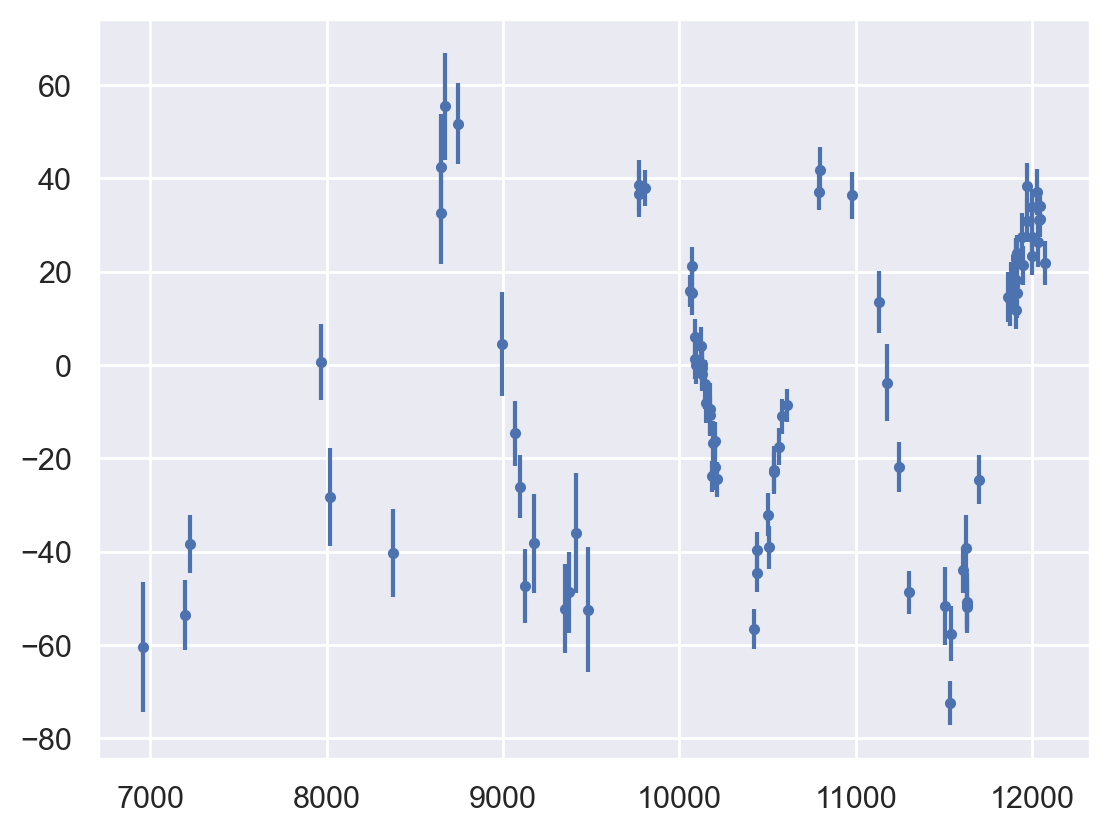

In [6]:
# YOUR CODE HERE

plt.errorbar(t, rv, rv_err, fmt='.');

# The Model

The first important step is to define a mathematical (and computational) model of how the parameters of interest are reflected in our observations.

Some references relating to what we're going to compute below:

- Balan 2009: http://adsabs.harvard.edu/abs/2009MNRAS.394.1936B
- Exofit Manual: http://www.star.ucl.ac.uk/~lahav/ExoFitv2.pdf
- Hou 2014: http://arxiv.org/pdf/1401.6128.pdf

The equation for radial velocity is this:

$$
v(t) = V - K[ \sin(f + \omega) + e \sin(\omega)]
$$

where $V$ is the overall velocity of the system, and

$$
K = \frac{m_p}{m_s + m_p} \frac{2\pi}{T}\frac{a \sin i}{\sqrt{1 - e^2}}
$$

The true anomaly $f$ satisfies

$$
\cos(f) = \frac{\cos(E) - e}{1 - e\cos E}
$$

Rearranging this we can write
$$
f = 2 \cdot{\rm atan2}\left(\sqrt{1 + e}\sin(E/2), \sqrt{1 - e} \cos(E/2)\right)
$$

The eccentric anomaly $E$ satisfies
$$
M = E - e\sin E
$$

and the mean anomaly is
$$
M = \frac{2\pi}{T}(t + \tau)
$$

and $\tau$ is the time of pericenter passage, which we'll parametrize with the parameter $\chi = \tau /  T$

These are the parameters needed to compute the radial velocity:

- $T$: orbital period
- $K$: amplitude of RV oscillation
- $V$: secular offset of RV oscillation
- $e$: eccentricity
- $\omega$: longitude of periastron
- $\chi$: dimensionless phase offset

Additionally, we will fit a scatter parameter $s$ which accounts for global data errors not reflected in the reported uncertainties (this is very similar to the third parameter from the linear fit we saw earlier)

For convenience, we'll store these parameters in a ``namedtuple``:

In [7]:
# RUN THIS
params = namedtuple('params', ['T', 'e', 'K', 'V', 'omega', 'chi', 's'])

# These just define the model we wrote down

In [8]:
# RUN THIS

@np.vectorize
def compute_E(M, e):
    """Solve Kepler's eqns for eccentric anomaly given mean anomaly"""
    f = lambda E, M=M, e=e: E - e * np.sin(E) - M
    return optimize.brentq(f, 0, 2 * np.pi)


def radial_velocity(t, theta):
    """Compute radial velocity given orbital parameters"""
    T, e, K, V, omega, chi = theta[:6]
    
    # compute mean anomaly (0 <= M < 2pi)
    M = 2 * np.pi * ((t / T + chi) % 1)
    
    # solve for eccentric anomaly
    E = compute_E(M, e)
    
    # compute true anomaly
    f = 2 * np.arctan2(np.sqrt(1 + e) * np.sin(E / 2),
                       np.sqrt(1 - e) * np.cos(E / 2))
    
    # compute radial velocity
    return V - K * (np.sin(f + omega) + e * np.sin(omega))

# The Likelihood and Priors

In [9]:
# RUN THIS

theta_lim = params(T=(0.2, 2000),
                   e=(0, 1),
                   K=(0.01, 2000),
                   V=(-2000, 2000),
                   omega=(0, 2 * np.pi),
                   chi=(0, 1),
                   s=(0.001, 100))
theta_min, theta_max = map(np.array, zip(*theta_lim))

def log_prior(theta):
    if np.any(theta < theta_min) or np.any(theta > theta_max):
        return -np.inf # log(0)
    
    # Jeffreys Prior on T, K, and s
    return -np.sum(np.log(theta[[0, 2, 6]]))

def log_likelihood(theta, t, rv, rv_err):
    sq_err = rv_err ** 2 + theta[6] ** 2
    rv_model = radial_velocity(t, theta)
    return -0.5 * np.sum(np.log(sq_err) + (rv - rv_model) ** 2 / sq_err)

def log_posterior(theta, t, rv, rv_err):
    ln_prior = log_prior(theta)
    if np.isinf(ln_prior):
        return ln_prior
    else:
        return ln_prior + log_likelihood(theta, t, rv, rv_err)
    
def make_starting_guess(t, rv, rv_err):
    model = LombScargleFast()
    model.optimizer.set(period_range=theta_lim.T,
                        quiet=True)
    model.fit(t, rv, rv_err)

    rv_range = 0.5 * (np.max(rv) - np.min(rv))
    rv_center = np.mean(rv)
    return params(T=model.best_period,
                  e=0.1,
                  K=rv_range,
                  V=rv_center,
                  omega=np.pi,
                  chi=0.5,
                  s=rv_err.mean())

# Now use my initial guess and sample the model

In [10]:
theta_guess = make_starting_guess(t, rv, rv_err)
theta_guess

ndim = len(theta_guess)  # number of parameters in the model
nwalkers = 50  # number of MCMC walkers

# start with a tight distribution of theta around the initial guess
rng = np.random.RandomState(42)
starting_guesses = theta_guess * (1 + 0.1 * rng.randn(nwalkers, ndim))

# RUN MCMC - YOUR CODE HERE
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=(t, rv, rv_err))
sampler.random_state = rng
pos, prob, state = sampler.run_mcmc(starting_guesses, 1000)

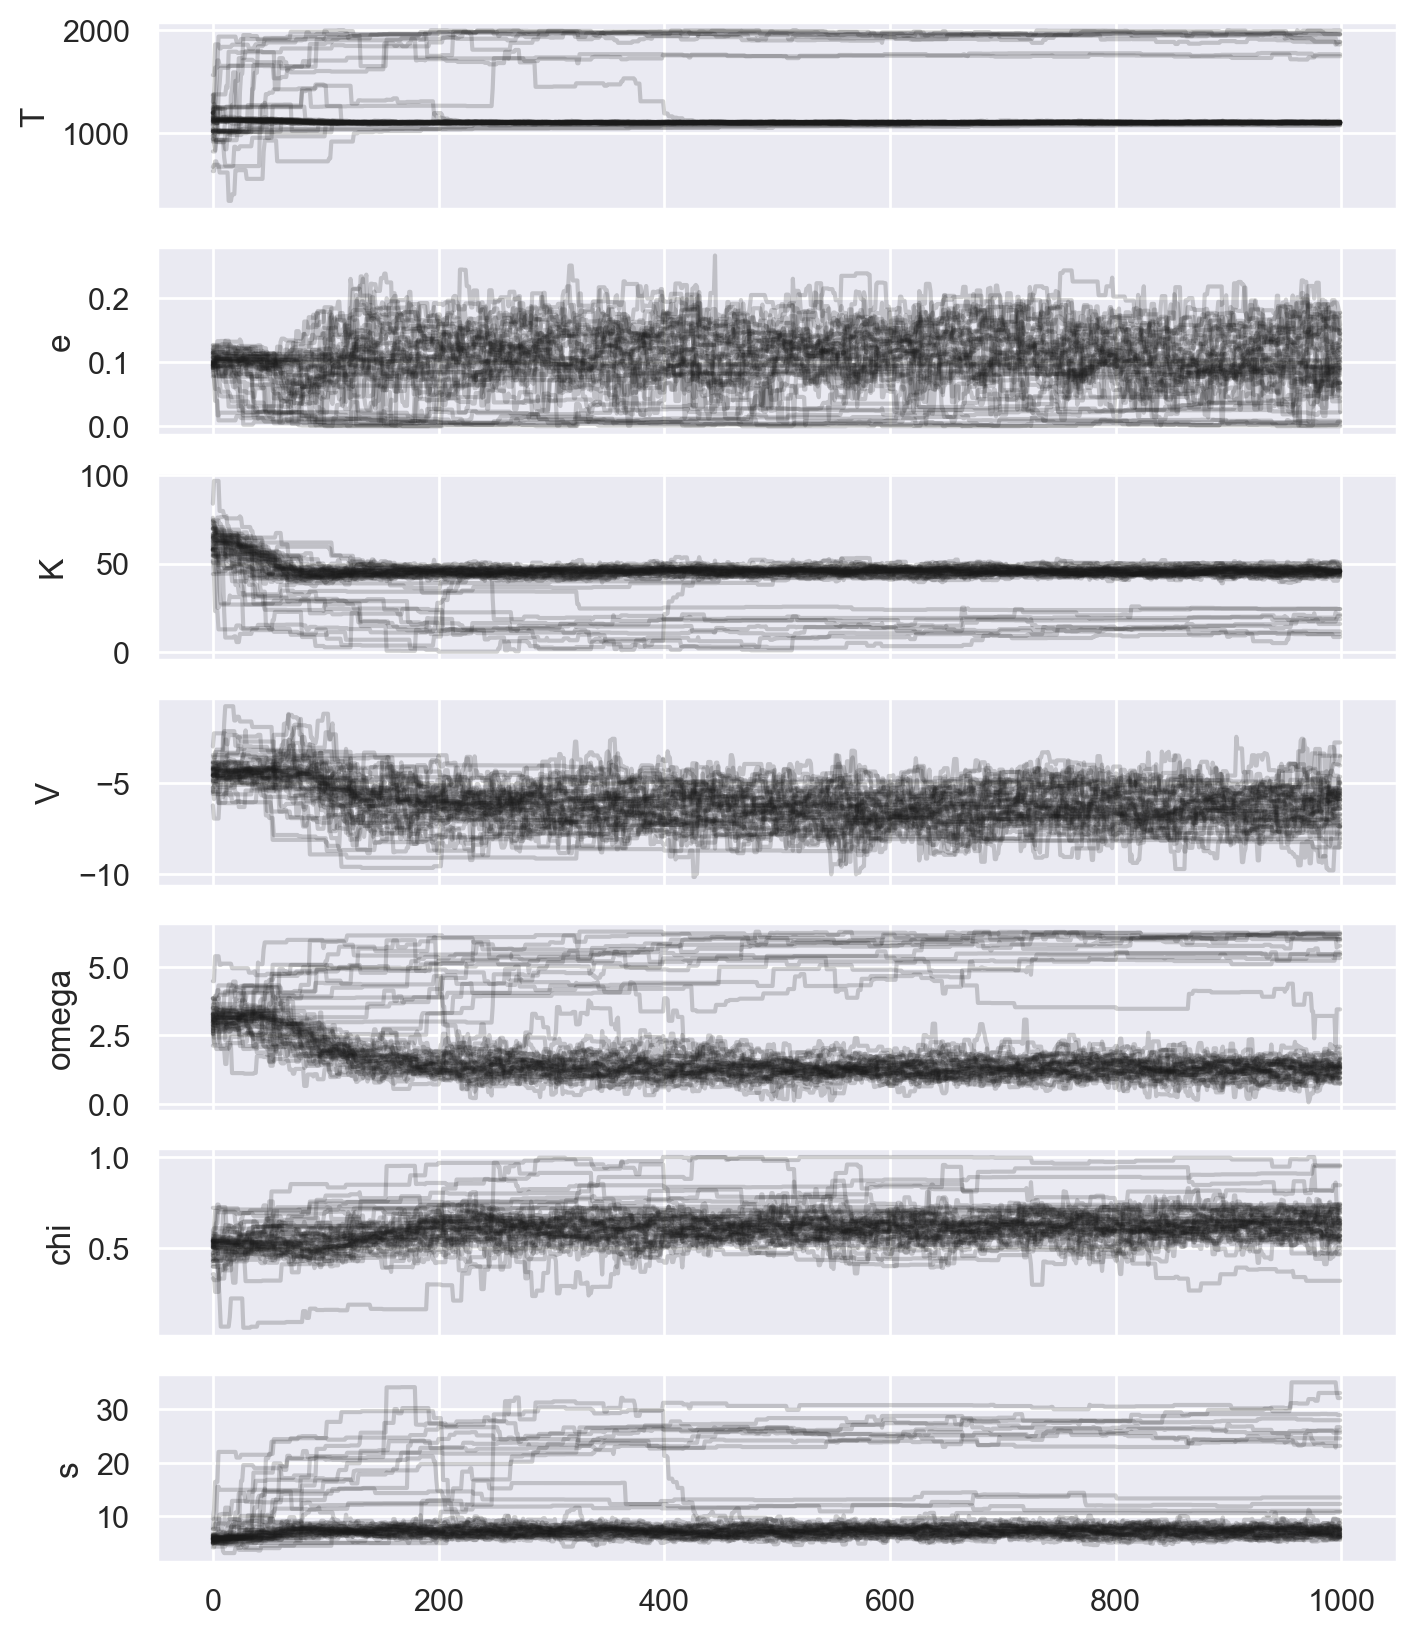

In [11]:
# This is a little function to plot the chains - you should be able to use this on your midterms 
def plot_chains(sampler):
    fig, ax = plt.subplots(ndim, figsize=(8, 10), sharex=True)
    for i in range(ndim):
        ax[i].plot(sampler.chain[:, :, i].T, '-k', alpha=0.2);
        ax[i].set_ylabel(params._fields[i])

        
# PLOT YOUR CHAINS - YOUR CODE HERE
plot_chains(sampler)

## As we've seen before the initial steps in the chain aren't useful samples and it takes a while to reach a stationary distribution. Notice though that the chains are *NOT* all mixed - there are some that are wandering away from the the remaining traces, and being stubborn about it.

In [12]:
# RUN A FULL MCMC HERE RESETING THE SAMPLER AND RESTARTING FROM THE LAST POSITION AFTER THE BURN-IN
# YOUR CODE HERE
sampler.reset()
pos, prob, state = sampler.run_mcmc(pos, 1000)

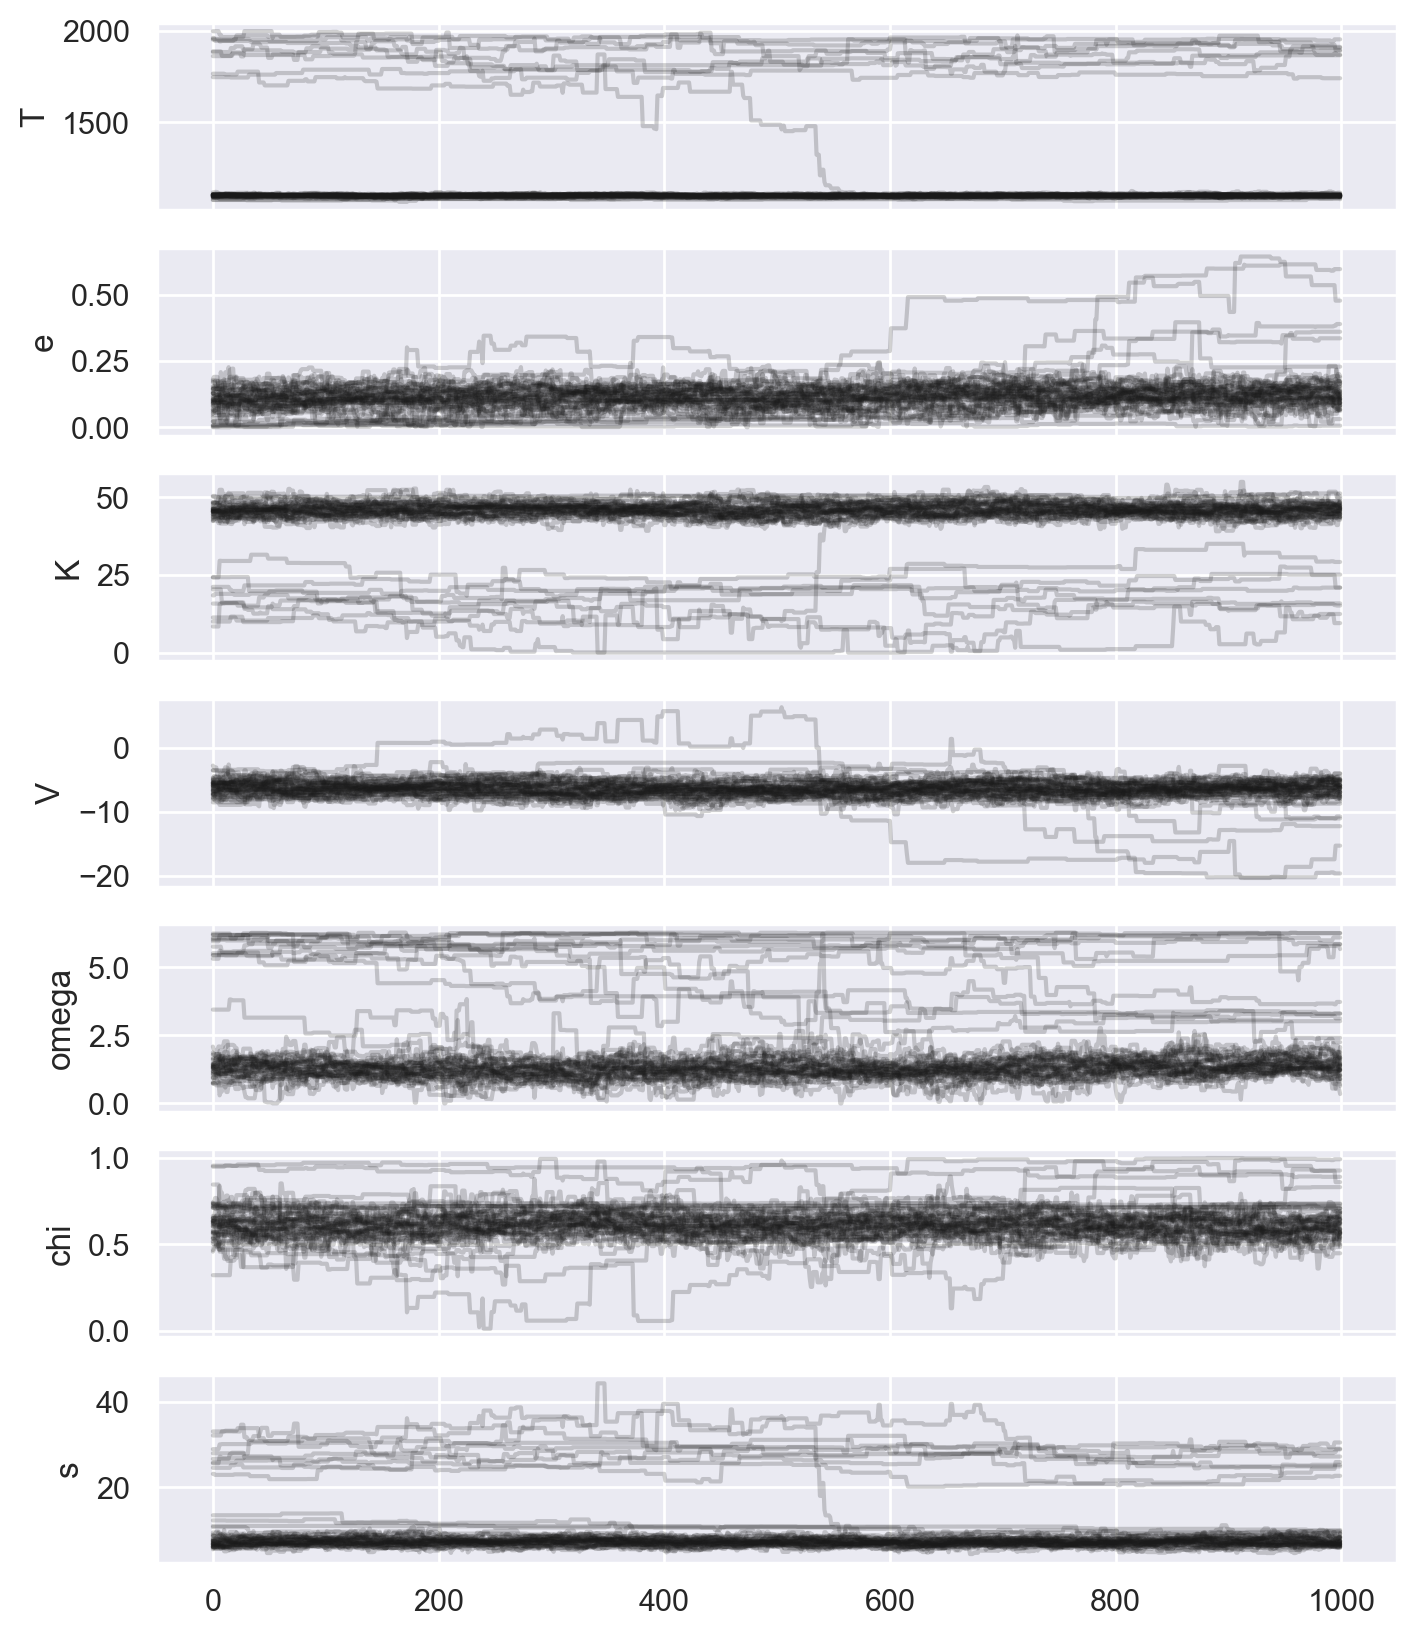

In [13]:
# PLOT YOUR CHAINS AGAIN - YOUR CODE HERE
plot_chains(sampler)

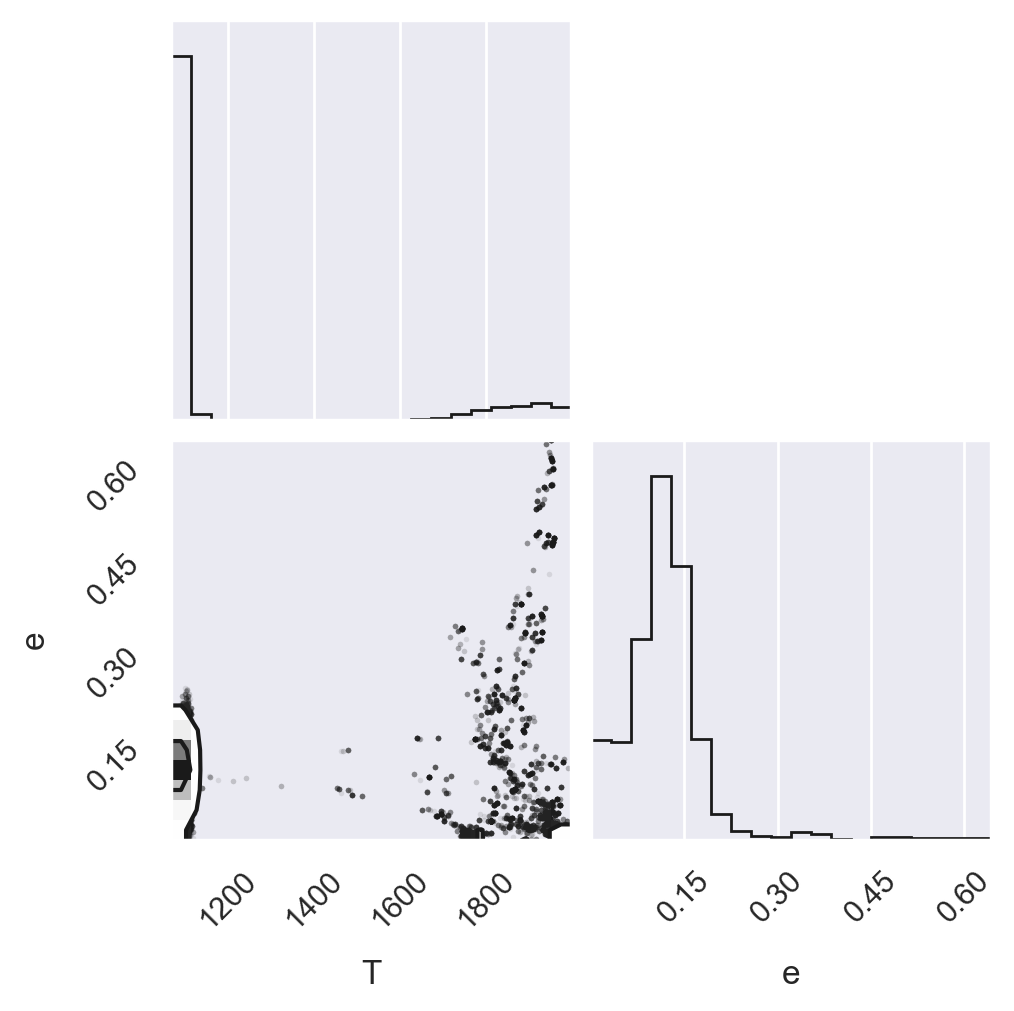

In [14]:
# AND LOOK AT THE PERIOD AND ECCENTRICITY 
# WE CAN'T GET MASSES FROM THE RADIAL VELOCITY METHOD, 
# BUT IF WE CARE ABOUT HABITABILITY, LOOKING AT e IS A GOOD IDEA
corner.corner(sampler.flatchain[:, :2], labels=params._fields[:2]);

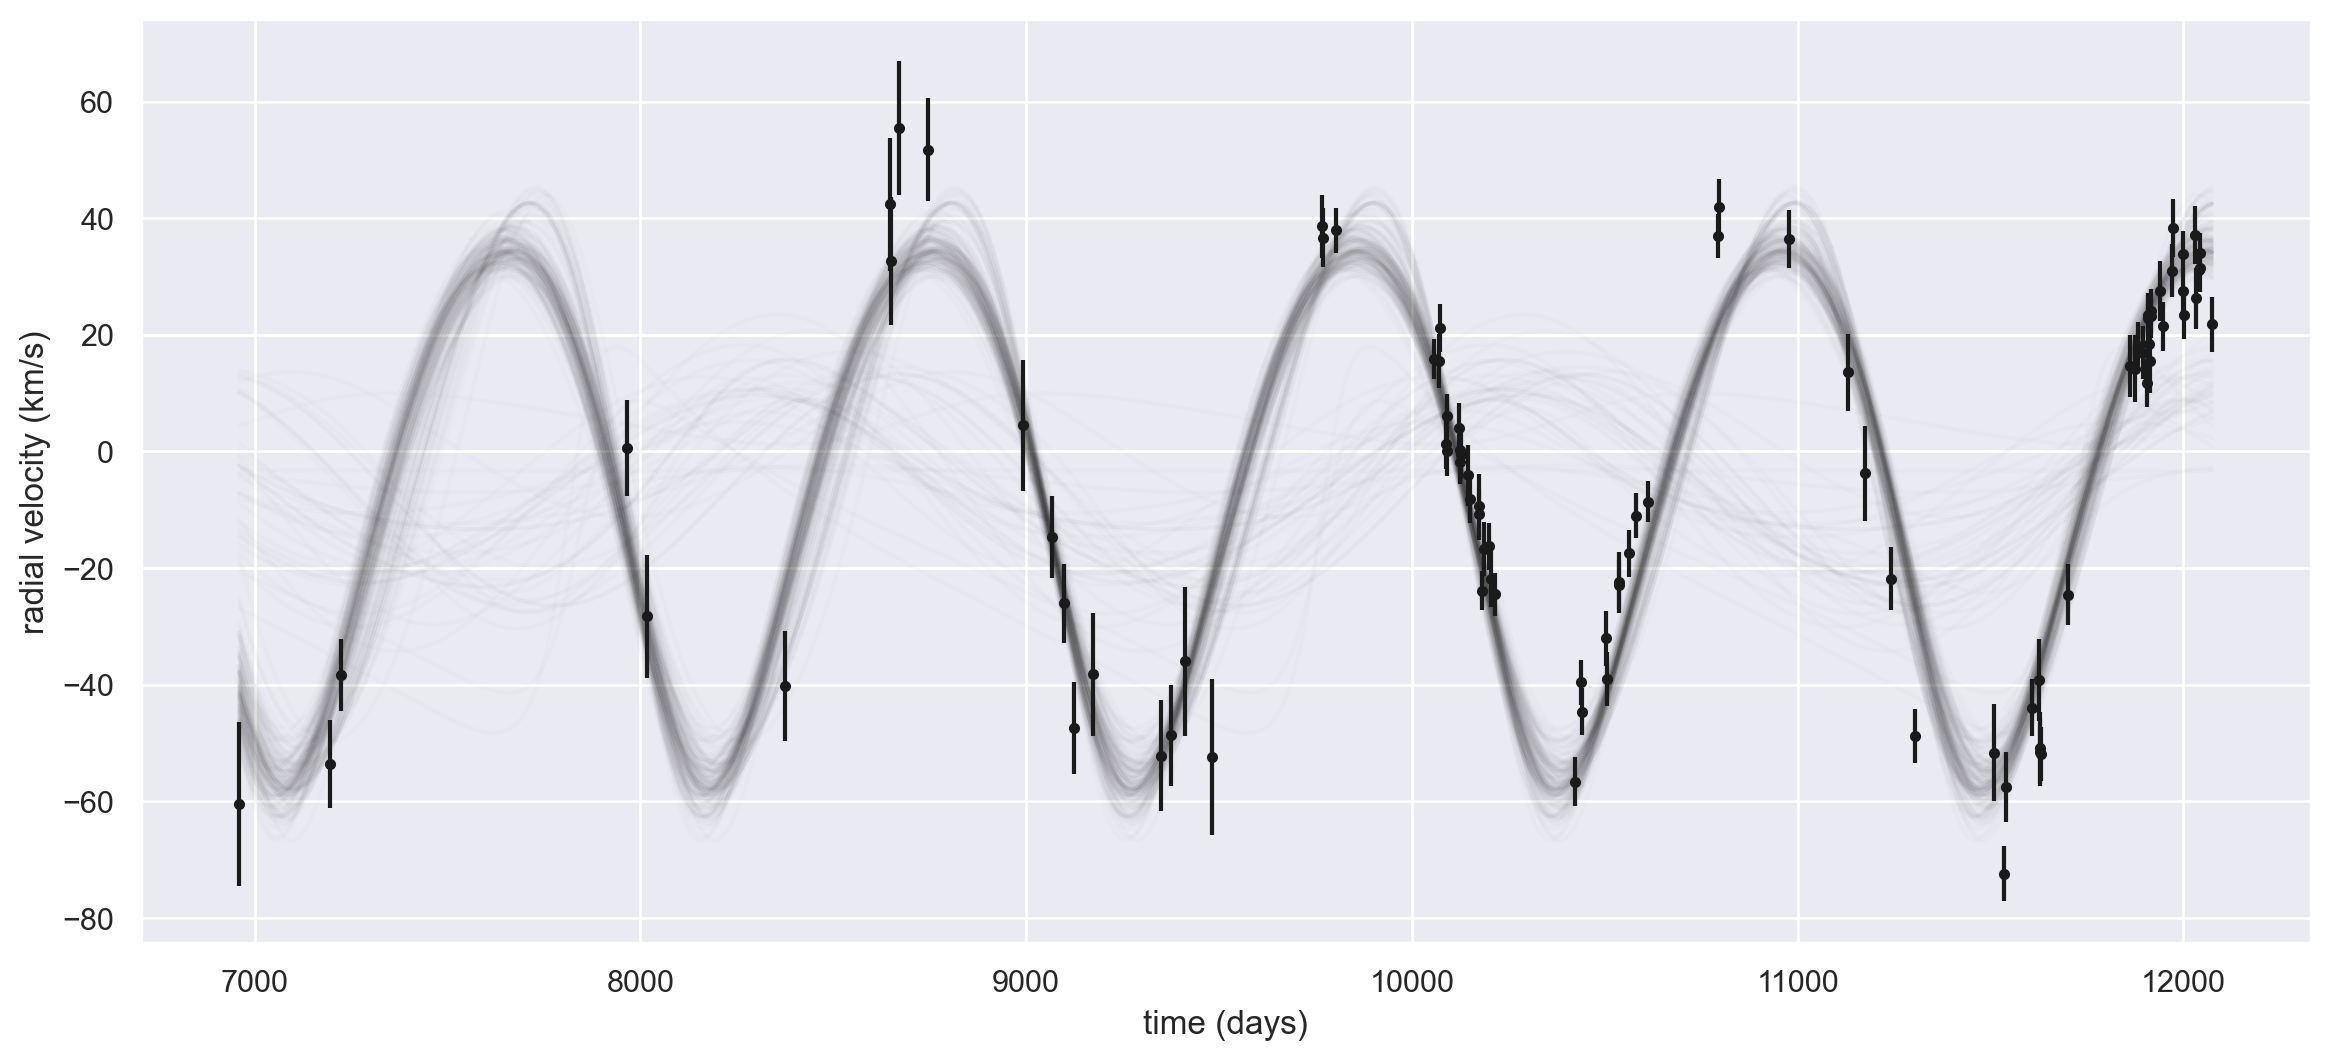

In [15]:
#RUN THIS TO VISUALIZE THE MODEL AGREEMENT WITH THE DATA
t_fit = np.linspace(t.min(), t.max(), 1000)
rv_fit = [radial_velocity(t_fit, sampler.flatchain[i])
          for i in rng.choice(sampler.flatchain.shape[0], 200)]

plt.figure(figsize=(14, 6))
plt.errorbar(t, rv, rv_err, fmt='.k')
plt.plot(t_fit, np.transpose(rv_fit), '-k', alpha=0.01)
plt.xlabel('time (days)')
plt.ylabel('radial velocity (km/s)');

In [16]:
# RUN THIS TO GET A SENSE OF THE PERIOD AND ECCENTRICITY
mean = sampler.flatchain.mean(0)
std = sampler.flatchain.std(0)

print("Period       = {0:.0f} +/- {1:.0f} days".format(mean[0], std[0]))
print("eccentricity = {0:.2f} +/- {1:.2f}".format(mean[1], std[1]))

Period       = 1230 +/- 290 days
eccentricity = 0.12 +/- 0.07


# In reality this system has multiple likely planets - see if you can find the second one by using the residuals to the first as your observations.

Period       = 1100 +/- 7 days
eccentricity = 0.12 +/- 0.04


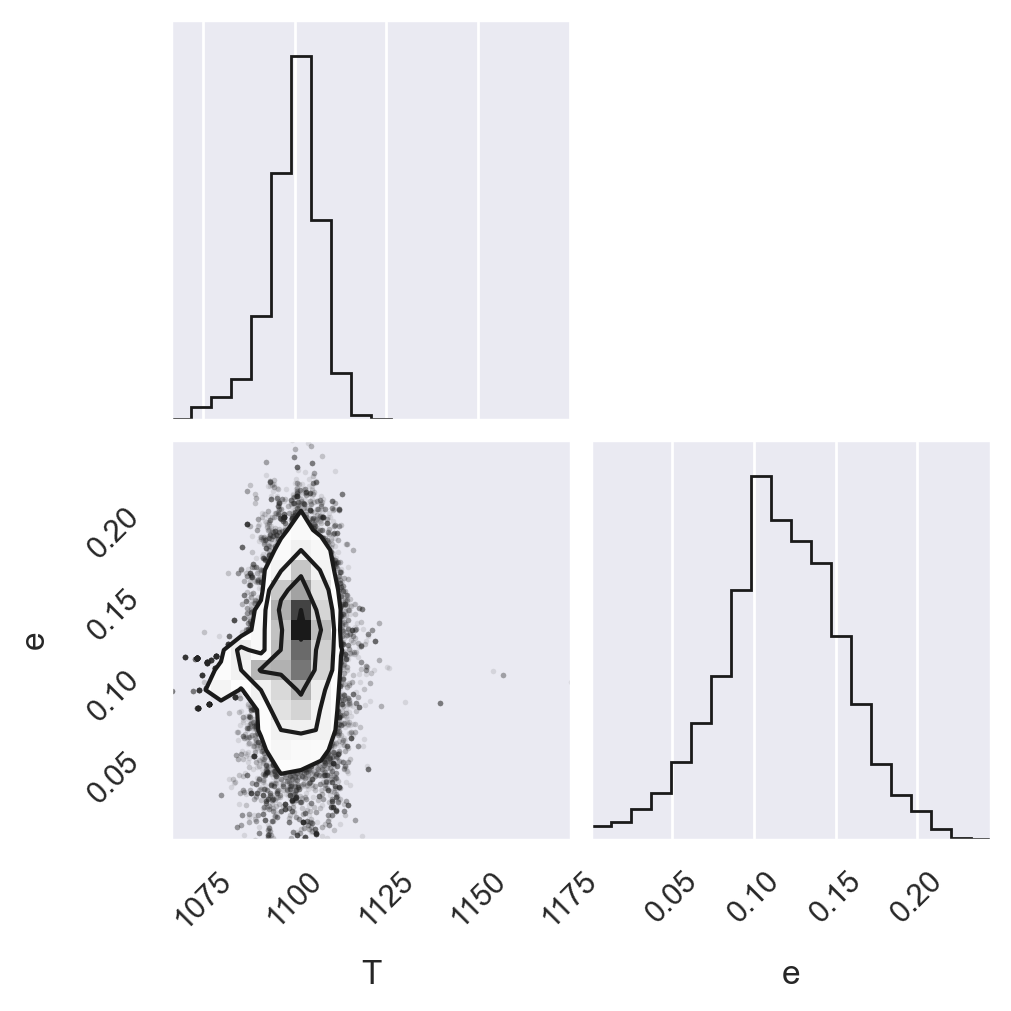

In [17]:
# RUN THIS
chain = sampler.flatchain[sampler.flatchain[:, 0] < 1200]
mean = chain.mean(0)
std = chain.std(0)

print("Period       = {0:.0f} +/- {1:.0f} days".format(mean[0], std[0]))
print("eccentricity = {0:.2f} +/- {1:.2f}".format(mean[1], std[1]))
corner.corner(chain[:, :2], 
              labels=params._fields[:2]);